### Augment the PythonPath so python can find necessary code.

In [1]:
import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('/home/andalman/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('/home/andalman/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('/home/andalman/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

### Import useful python packages

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims
import tqdm
import numpy as np
import pandas as pd
import scipy
import skimage.io
import visualization_utils as vizutil
import seaborn as sns
from skimage.filters import gaussian_filter

### Load the data

hbstim_imaging_utils provides a list of all the datasets and provides a helper class to make loading the data easy.

The data_sets are split into two conditions:  
'c': chr2 negative fish (n=4)  
'e': chr2 positive fish (n=6)  
  
all_data is a dictionary keyed by the condition.  
all_data[condition] contains a list of HbStim_Fish objects.

In [4]:
import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

print 'c, n =', len(all_data['c'])
print 'e, n =', len(all_data['e'])

c, n = 8
e, n = 12


### Passivity_2p_Fish Class

The `Passivity_2p_Fish` class offers various members and methods for loading data associated with each fish.

In [11]:
#Grab the first experimental fish
f = all_data.e[1] 
print 'Num z-planes imaged:', f.num_zplanes
print 'Volume-Rate:', 1/np.diff(f.frame_st[:,0]).mean() #frame_st is #frames x #slices, we examine interval between imaging first slice
print 'Movement Times', f.forward_swim_times
print 'Shock times', f.shock_st

Num z-planes imaged: 6
Volume-Rate: 1.1111239123614585
Movement Times [  22.5944   23.6027   24.6611   27.0445   29.7863   30.5864   31.5697
   32.3114   35.2532   38.1283   41.1618   42.0035   43.6702   44.4286
   46.5537   48.0704   49.2871   51.7372   52.6039   54.3623   55.9791
   56.8958   58.7292   59.5125   61.5376   63.2627   65.2961   66.9712
   67.6546   69.463    71.3964   73.3048   74.9132   76.8299   78.7467
   80.9634   82.3468   84.4802   89.3888   90.8472   93.1306   95.0807
   97.4724   99.0308  103.6227  105.9061  107.5062  108.4479  111.673
  114.7398  117.0982  119.8067  121.3901  122.8318  125.9736  128.0154
  131.5572  133.4073  136.5741  140.5576  144.5077  146.3245  151.558
  157.8833  158.9     162.6251  164.7085  167.3003  171.8588  175.584
  178.6674  180.5342  184.3843  188.1262  199.5016  202.2101  204.8685
  215.794   224.711   228.8362  662.7373  663.7624  946.5073  989.9341
 1045.5447 1057.0535 1064.5622 1064.7289 1066.3539 1650.2113 1650.5279
 1651.0446

The `get_roi_table` method returns a dataframe of all the rois for teh fish.  Each row of this table represents an ROI and specified the place the ROI is in, the pixels that are included in the ROI, the centroid of the ROI, and which brain regions the ROI is in.  

Note, this data is older and was processed by simply segmenting the anatomical images.  Thus the data is does not look as clean as data that is cleaned up and processed using CNMF, for example.

In [12]:
df = f.get_roi_table() #this can be slow to run the first time as data is loaded from files
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01531,0,0,1,"[[1, 118], [1, 119], [1, 120], [1, 121], [1, 1...",1.933333,120.400000,15,0.937500,0.874444,...,False,False,False,False,False,False,False,other,w,other
1,f01531,0,1,2,"[[1, 126], [1, 127], [1, 128], [1, 129], [1, 1...",2.071429,127.642857,14,1.000000,0.698898,...,False,False,False,False,False,False,False,other,w,other
2,f01531,0,2,3,"[[0, 263], [1, 260], [1, 261], [1, 262], [1, 2...",2.000000,262.578947,19,0.826087,0.739813,...,False,False,False,False,False,False,False,other,w,other
3,f01531,0,3,4,"[[1, 292], [1, 293], [1, 294], [1, 295], [1, 2...",1.941176,294.352941,17,1.000000,0.875727,...,False,False,False,False,False,False,False,other,w,other
4,f01531,0,4,5,"[[1, 298], [1, 299], [1, 300], [1, 301], [1, 3...",1.933333,300.266667,15,0.937500,0.763716,...,False,False,False,False,False,False,False,other,w,other


'get_signals_raw' returns a matrix containing the raw fluorescent signal associated with each ROI.  Each row of this matrix is associated with the corresponding row of the ROI table.  

Note, I only use the second half of the signal matrix, because the agarose had not fully hardened during the first of imaging which cause the fish to drift in z slightly.

In [13]:
M = f.get_signals_raw(z=None)
#M = hbutils.df_over_f(M)
print 'Num ROIs:', df.shape[0]
print 'Shape of signal matrix', M.shape

Num ROIs: 7421
Shape of signal matrix (7421, 3010)


There are also various methods for grabbing the raw imaging data:  
get_tif_as_vol  
get_tif_rasl

We can use this to visualize a few ROIs in particular plane/slice and brain region:

(7421, 31)

multi


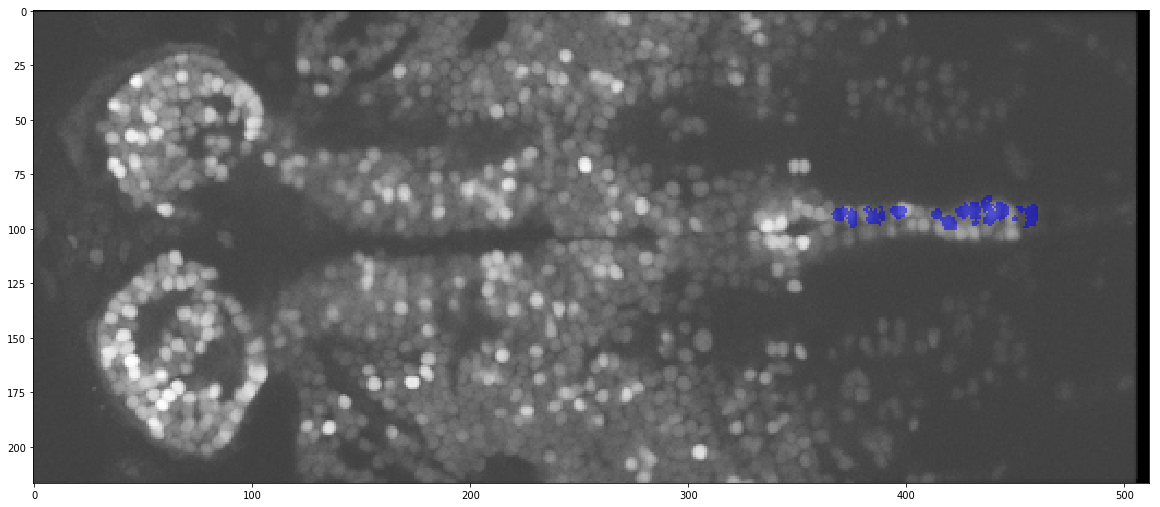

In [34]:
z=5

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
coords = df[(df.in_r_raphe) & (df.z==z)].coords

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')